In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

In [3]:
import sys

sys.path.append('../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [7]:
%%time
N,D = 2*10**5, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
kw_cluster =  {'f_class_name':'circle_class', 'centers': [0.5, 0.5], 'r_small': 0.2, 'r_big':0.4}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 3
stats = np.array([[1, std], [0, std], [1, std], [1, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

CPU times: user 89.9 ms, sys: 39 ms, total: 129 ms
Wall time: 127 ms


In [8]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500673,0.501111,0.376430,0.498100,0.826633,0.822176,0.386218
std,0.288431,0.289314,0.484492,0.499999,5.006229,5.022395,7.094485
min,0.000029,0.000003,0.000000,0.000000,-20.722443,-19.815324,-28.576548
25%,0.250571,0.249306,0.000000,0.000000,-2.558247,-2.554022,-4.397222
50%,0.502989,0.500945,0.000000,0.000000,0.814892,0.810950,0.414810
75%,0.750030,0.752974,1.000000,1.000000,4.228233,4.192144,5.192659
max,0.999975,0.999999,1.000000,1.000000,21.278586,22.859837,30.116766


In [9]:
mpl.style.use(['seaborn-paper'])
#mpl.rcParams.update(mpl.rcParamsDefault)


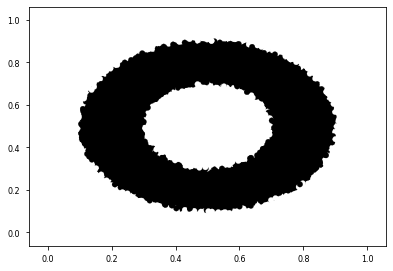

In [10]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys')


plt.show()

In [11]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 6.49 s, sys: 3.45 ms, total: 6.49 s
Wall time: 6.49 s


In [12]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR
0,0.548814,0.715189,1,0,2.966992,6.251330,3.284338,0,0.698076,-2.268916
1,0.602763,0.544883,0,1,-1.391835,3.239140,-4.630975,0,0.540906,-1.932741
2,0.423655,0.645894,0,1,3.073495,2.126842,0.946653,0,0.676234,2.397260
3,0.437587,0.891773,1,1,-3.256552,-2.952716,-0.303836,1,0.672395,-3.928947
4,0.963663,0.383442,0,0,4.395566,7.384828,2.989262,0,1.128294,-3.267271


### Model performance

In [13]:
filt = (data['Treatment'] == 1) & (data['C'] == 1)
data.groupby(['Treatment', 'C'])[['Y', 'Ycf', 'Ycf-GDBR','ITE', 'ITE-GDBR']].mean()

Y       Ycf  Ycf-GDBR       ITE  ITE-GDBR
Treatment C                                                  
0         0  0.977147  1.017817  1.022641  0.040670  0.045494
          1  0.075470  1.012868  1.029104  0.937398  0.953635
1         0  1.005359  1.023804  0.797251 -0.018445  0.208108
          1  1.042080 -0.037123  0.418049  1.079203  0.624031

### Apply clustering 

In [14]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = 17**2, col_select = col_select )
data,_ = kmeans_clustering(data.copy(), clusters = 17**2, col_select = col_select )
#data,_ = agglomerative_clustering(data.copy(), clusters = 100, col_select = col_select )

CPU times: user 57min 17s, sys: 5.16 s, total: 57min 22s
Wall time: 1min 20s


In [15]:
data.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,1,0,2.966992,6.251330,3.284338,0,0.698076,-2.268916,213,143
1,0.602763,0.544883,0,1,-1.391835,3.239140,-4.630975,0,0.540906,-1.932741,163,234
2,0.423655,0.645894,0,1,3.073495,2.126842,0.946653,0,0.676234,2.397260,177,207
3,0.437587,0.891773,1,1,-3.256552,-2.952716,-0.303836,1,0.672395,-3.928947,262,163
4,0.963663,0.383442,0,0,4.395566,7.384828,2.989262,0,1.128294,-3.267271,118,70


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [16]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name, hom_name = 'Box-Hom')

kmeans = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name, hom_name = 'Kmeans-Hom')

#agglo = ATTC(data.copy(), cluster_name = 'Agglomerative-Cluster', ATT_CLUST_name='Agglo-ATT',
#           points_name='Agglo-points', weight_names='Agglo-Weights',ITE_name = ite_name, hom_name = 'Agglo-Hom')

In [17]:
kmeans

,Kmeans-Cluster,Kmeans-ATT,Kmeans-points,Kmeans-Hom,Kmeans-Weights
0,0,0.196231,188.0,1.000000,0.003774
1,1,1.128648,160.0,1.000000,0.003212
2,2,1.038782,193.0,1.000000,0.003875
3,3,1.504912,161.0,1.000000,0.003232
4,4,-0.504910,162.0,1.000000,0.003252
...,...,...,...,...,...
284,284,-0.345657,177.0,1.000000,0.003554
285,285,-0.008176,187.0,1.000000,0.003754
286,286,0.691472,169.0,0.656805,0.003393
287,287,0.180744,180.0,1.000000,0.003614


In [18]:
box

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,-0.029805,171.0,1.0,0.003433
1,1,-0.811247,169.0,1.0,0.003393
2,2,-0.440124,164.0,1.0,0.003293
3,3,-0.111390,140.0,1.0,0.002811
4,4,-1.131818,163.0,1.0,0.003272
...,...,...,...,...,...
284,284,-0.091361,173.0,1.0,0.003473
285,285,-0.025191,160.0,1.0,0.003212
286,286,-0.108974,175.0,1.0,0.003513
287,287,0.127619,165.0,1.0,0.003313


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


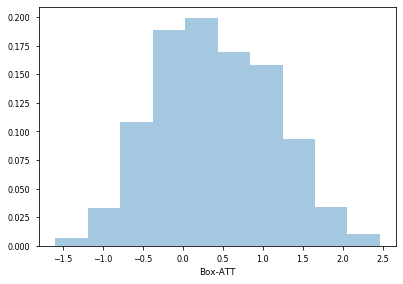

In [19]:
kde = False
bins = 10
sns.distplot(box['Box-ATT'], hist_kws={'weights':box['Box-Weights'].values},bins = bins, kde = kde)
plt.show()

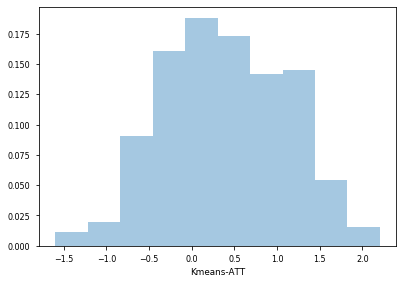

In [20]:
sns.distplot(kmeans['Kmeans-ATT'], hist_kws={'weights':kmeans['Kmeans-Weights'].values},bins = bins, kde = kde)
plt.show()

In [21]:
#sns.distplot(agglo['Agglo-ATT'], hist_kws={'weights':agglo['Agglo-Weights'].values},bins = bins, kde = kde )
#plt.show()

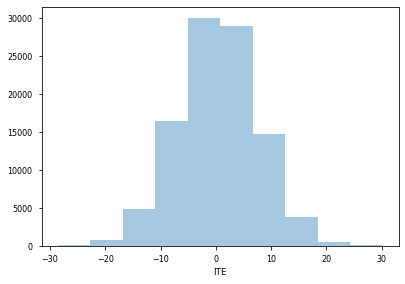

In [22]:
sns.distplot(data['ITE'], bins = 10, kde = kde)
plt.show()

In [23]:
#agglo.describe()

In [24]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,289.000000,289.000000,289.000000,289.000000,289.000000
mean,144.000000,0.392082,172.352941,0.953238,0.003460
std,83.571327,0.725347,13.207742,0.099830,0.000265
min,0.000000,-1.596588,139.000000,0.539773,0.002791
25%,72.000000,-0.134974,163.000000,0.972414,0.003272
50%,144.000000,0.373780,172.000000,1.000000,0.003453
75%,216.000000,0.933727,182.000000,1.000000,0.003654
max,288.000000,2.463953,209.000000,1.000000,0.004196


In [25]:
kmeans.describe()

,Kmeans-Cluster,Kmeans-ATT,Kmeans-points,Kmeans-Hom,Kmeans-Weights
count,289.000000,289.000000,289.000000,289.000000,289.000000
mean,144.000000,0.389843,172.352941,0.949640,0.003460
std,83.571327,0.726787,18.263693,0.116784,0.000367
min,0.000000,-1.600447,129.000000,0.509554,0.002590
25%,72.000000,-0.182558,161.000000,0.993865,0.003232
50%,144.000000,0.365887,172.000000,1.000000,0.003453
75%,216.000000,0.965447,184.000000,1.000000,0.003694
max,288.000000,2.206047,223.000000,1.000000,0.004477


### Calculate ATT per Cluster not known Model Calculated CF

In [26]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name, hom_name = 'Box-Hom')

kmeans2 = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name, hom_name = 'Kmeans-Hom')

#agglo2 = ATTC(data.copy(), cluster_name = 'Agglomerative-Cluster', ATT_CLUST_name='Agglo-ATT',
        #   points_name='Agglo-points', weight_names='Agglo-Weights',ITE_name = ite_name, hom_name = 'Agglo-Hom')

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


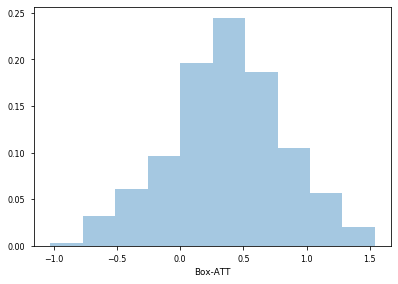

In [27]:
kde = False
bins = 10
sns.distplot(box2['Box-ATT'], hist_kws={'weights':box2['Box-Weights'].values},bins = bins, kde = kde, )
plt.show()

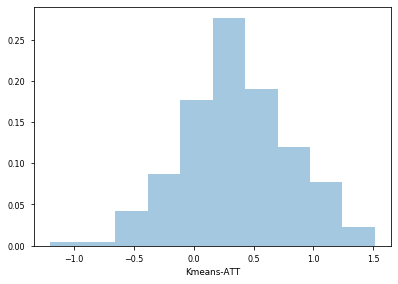

In [28]:
sns.distplot(kmeans2['Kmeans-ATT'], hist_kws={'weights':kmeans2['Kmeans-Weights'].values},bins = bins, kde = kde)
plt.show()

In [29]:
#sns.distplot(agglo2['Agglo-ATT'], hist_kws={'weights':agglo2['Agglo-Weights'].values}, bins = bins,kde = kde )
#plt.show()

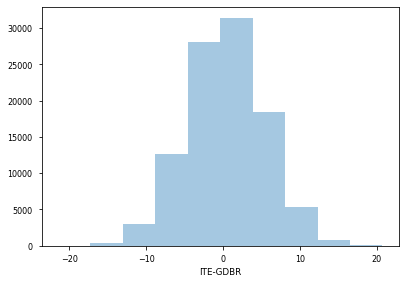

In [30]:
sns.distplot(data['ITE-GDBR'],bins = bins, kde = kde)
plt.show()

### Weighted Kmeans 2-Clustering

In [31]:
%%time
#all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
all_data = [box, kmeans, box2, kmeans2]

#names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
#names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']

names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']
names2 = ['Box-ATT', 'Kmeans-ATT',  'Box-ATT', 'Kmeans-ATT']

weights = ['Box-Weights', 'Kmeans-Weights', 'Box-Weights', 'Kmeans-Weights']

for dd, name, name2,w in zip(all_data, names, names2,weights):
    kmeans_clustering(dd, clusters = 2, col_select = [name2], 
                      cluster_name = name, fit_kwargs={'sample_weight':dd[w].values} )

CPU times: user 214 ms, sys: 4 ms, total: 218 ms
Wall time: 110 ms


In [32]:
box['Box-Cl2'].sum()

128

In [33]:
box.head()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,-0.029805,171.0,1.0,0.003433,0
1,1,-0.811247,169.0,1.0,0.003393,0
2,2,-0.440124,164.0,1.0,0.003293,0
3,3,-0.111390,140.0,1.0,0.002811,0
4,4,-1.131818,163.0,1.0,0.003272,0


In [34]:
data2 = data.copy()

In [35]:
data2.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,1,0,2.966992,6.251330,3.284338,0,0.698076,-2.268916,213,143
1,0.602763,0.544883,0,1,-1.391835,3.239140,-4.630975,0,0.540906,-1.932741,163,234
2,0.423655,0.645894,0,1,3.073495,2.126842,0.946653,0,0.676234,2.397260,177,207
3,0.437587,0.891773,1,1,-3.256552,-2.952716,-0.303836,1,0.672395,-3.928947,262,163
4,0.963663,0.383442,0,0,4.395566,7.384828,2.989262,0,1.128294,-3.267271,118,70


### 2 Clustering in the ITEs

In [36]:
data2,_ = kmeans_clustering(data2,clusters = 2, cluster_name = 'ITE-CTrue',col_select = ['ITE'] )
data2,_ = kmeans_clustering(data2,clusters = 2, cluster_name = 'ITE-CGDBR',col_select = ['ITE-GDBR'] )

In [37]:
data2,_ = box_clustering(data2, clusters = 10**4, cluster_name = 'C2-Avg', col_select = col_select)

In [38]:
data2.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-CTrue,ITE-CGDBR,C2-Avg
0,0.548814,0.715189,1,0,2.966992,6.251330,3.284338,0,0.698076,-2.268916,213,143,1,0,7154
1,0.602763,0.544883,0,1,-1.391835,3.239140,-4.630975,0,0.540906,-1.932741,163,234,0,0,5460
2,0.423655,0.645894,0,1,3.073495,2.126842,0.946653,0,0.676234,2.397260,177,207,1,1,6442
3,0.437587,0.891773,1,1,-3.256552,-2.952716,-0.303836,1,0.672395,-3.928947,262,163,0,0,8943
4,0.963663,0.383442,0,0,4.395566,7.384828,2.989262,0,1.128294,-3.267271,118,70,1,0,3896


In [39]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

merge_names = ['Box-Cluster', 'Kmeans-Cluster']*2
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name]]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

In [40]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2',
            #    'Agglo2-Cl2','ITE-CTrue', 'ITE-CGDBR']

avg_c = data2.groupby('C2-Avg')[class_names].mean().reset_index()

In [41]:
data2 = data2.merge(avg_c, on = 'C2-Avg', how = 'left', suffixes=("","y"))

In [42]:
data2.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-CTrue,ITE-CGDBR,C2-Avg,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2,Box-Cl2y,Kmeans-Cl2y,Box2-Cl2y,Kmeans2-Cl2y
0,0.548814,0.715189,1,0,2.966992,6.251330,3.284338,0,0.698076,-2.268916,213,143,1,0,7154,1,1,0,1,1.0,1.0,0.000,1.0
1,0.602763,0.544883,0,1,-1.391835,3.239140,-4.630975,0,0.540906,-1.932741,163,234,0,0,5460,0,0,0,1,0.0,0.0,0.000,1.0
2,0.423655,0.645894,0,1,3.073495,2.126842,0.946653,0,0.676234,2.397260,177,207,1,1,6442,0,0,0,0,0.0,0.0,0.125,0.0
3,0.437587,0.891773,1,1,-3.256552,-2.952716,-0.303836,1,0.672395,-3.928947,262,163,0,0,8943,0,0,0,0,0.0,0.0,0.000,0.0
4,0.963663,0.383442,0,0,4.395566,7.384828,2.989262,0,1.128294,-3.267271,118,70,1,0,3896,1,1,0,1,1.0,1.0,0.000,1.0


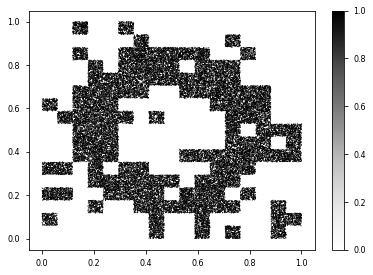

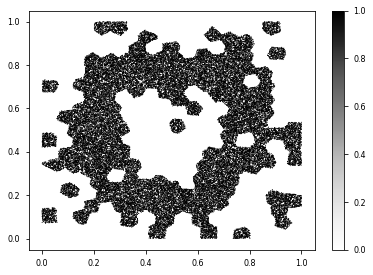

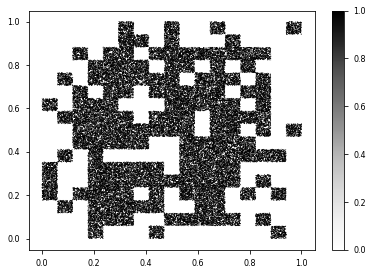

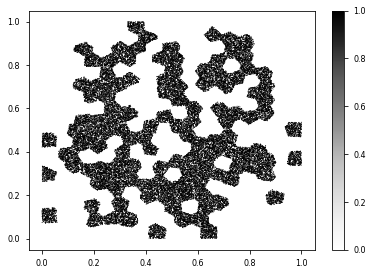

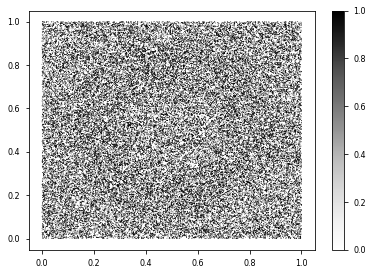

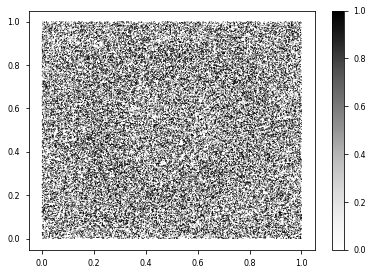

In [43]:
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']

class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Box2-Cl2',
                'Kmeans2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']

class_names2 = [name+'y' for name in class_names1]
for name in class_names1:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()

    sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 0.5)
    fig.colorbar(sc)

    plt.show()

In [44]:
plt.show()

### homogeneity experiment

In [45]:
clusters = [4, 16, 25, 100]
clustering_algo = ['box_clustering', 'kmeans_clustering', 'agglomerative_clustering']

In [46]:
result = get_homogeneity(data.copy(),clusters = clusters, clustering_algo = clustering_algo, col_select = col_select)

Running:box_clustering
Number of Clusters:4 algobox_clustering
Number of Clusters:16 algobox_clustering
Number of Clusters:25 algobox_clustering
Number of Clusters:100 algobox_clustering
Running:kmeans_clustering
Number of Clusters:4 algokmeans_clustering
Number of Clusters:16 algokmeans_clustering
Number of Clusters:25 algokmeans_clustering
Number of Clusters:100 algokmeans_clustering
Running:agglomerative_clustering
Number of Clusters:4 algoagglomerative_clustering
Number of Clusters:16 algoagglomerative_clustering
Number of Clusters:25 algoagglomerative_clustering
Number of Clusters:100 algoagglomerative_clustering


In [47]:
pd.DataFrame(result)

,clusters,box_clustering,kmeans_clustering,agglomerative_clustering
0,4,0.625918,0.625918,0.625918
1,16,0.626581,0.667015,0.720418
2,25,0.768360,0.788476,0.769825
3,100,0.938607,0.919354,0.908753
